# Notebook 08: Electronic Properties

## Calculate ONLY After Structure is Validated and Stable!

### Prerequisites Reminder

Before calculating electronic properties, ensure:

- ☑ Structure from reliable database
- ☑ Convergence testing complete
- ☑ Structure optimized
- ☑ **Stability verified** (thermodynamic, dynamic, mechanical)

**If ANY step is skipped → Results are MEANINGLESS!**

---

In [1]:
# =============================================================================
# SETUP - Run this cell first (downloads pseudopotentials automatically)
# =============================================================================

import sys
import json
from pathlib import Path
from typing import List, Tuple
import importlib.util
import re

_cwd = Path.cwd().resolve()
if (_cwd / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd))
elif (_cwd / 'notebooks_enhanced' / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd / 'notebooks_enhanced'))
else:
    raise FileNotFoundError("Cannot find workshop_setup.py. Run from the workshop root or notebooks_enhanced/")

from workshop_setup import *

from ase import Atoms
from ase.build import bulk
from ase.io.espresso import write_espresso_in

SEEKPATH_AVAILABLE = (importlib.util.find_spec('seekpath') is not None)
if SEEKPATH_AVAILABLE:
    import seekpath
    print("✓ seekpath available - automatic k-path generation")
else:
    print("⚠ seekpath not available. Install: pip install seekpath")

# =============================================================================
# >>> STUDENT: MODIFY THIS SECTION <<<
# =============================================================================

MATERIAL = 'Si'
STRUCTURE_TYPE = 'diamond'
LATTICE_A = 5.43

FUNCTIONAL = 'PBE'
# FUNCTIONAL = 'LDA'
# FUNCTIONAL = 'PBEsol'

# =============================================================================
# AUTOMATIC SETUP
# =============================================================================

atoms = bulk(MATERIAL, STRUCTURE_TYPE, a=LATTICE_A)
elements = list(set(atoms.get_chemical_symbols()))

pp_files = setup_pseudopotentials(elements, functional=FUNCTIONAL)
ecutwfc, ecutrho = get_recommended_cutoffs(elements, functional=FUNCTIONAL)
PSEUDO_DIR_FUNC = get_pseudo_dir(FUNCTIONAL)

# Load converged parameters from previous notebooks
params_file = WORKSHOP_ROOT / 'converged_parameters.json'
if params_file.exists():
    with open(params_file, 'r') as f:
        params = json.load(f)
    ecutwfc = float(params.get('ecutwfc', {}).get('recommended', ecutwfc))
    ecutrho_factor = float(params.get('ecutrho', {}).get('factor', 8))
    ecutrho = ecutwfc * ecutrho_factor
    kgrid = int(params.get('kpoints', {}).get('recommended', 8))
    print(f"✓ Loaded converged parameters from NB04")
else:
    kgrid = 8
    print("Using default parameters (run NB04 for converged values)")

WORK_DIR = OUTPUT_DIR / '08_electronic'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

print(f"\n{'='*70}")
print(f"ELECTRONIC PROPERTIES SETUP")
print(f"{'='*70}")
print(f"Material:   {MATERIAL} ({STRUCTURE_TYPE})")
print(f"Functional: {FUNCTIONAL}")
print(f"Cutoffs:    ecutwfc={ecutwfc} Ry, ecutrho={ecutrho} Ry")
print(f"K-grid:     {kgrid}x{kgrid}x{kgrid}")
print(f"{'='*70}")

⚠ seekpath not available. Install: pip install seekpath
PSEUDOPOTENTIAL SETUP - PBE
  ✓ Si: Si.pbe-n-rrkjus_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE
✓ Loaded converged parameters from NB04

ELECTRONIC PROPERTIES SETUP
Material:   Si (diamond)
Functional: PBE
Cutoffs:    ecutwfc=45.0 Ry, ecutrho=360.0 Ry
K-grid:     14x14x14


/home/niel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


---

## 1. Band Structure Calculation Workflow

```
Step 1: SCF calculation (dense k-mesh)
        ↓
Step 2: Bands calculation (k-path through BZ)
        ↓
Step 3: Post-processing with bands.x
        ↓
Step 4: Plot and analyze
```

In [2]:
# =============================================================================
# AUTOMATIC K-PATH GENERATION USING SEEKPATH
# =============================================================================
# seekpath finds the correct high-symmetry path for ANY crystal structure.
# This is more reliable than manually specifying paths.
# =============================================================================

def get_kpath_from_structure(atoms):
    """
    Get high-symmetry k-path using seekpath.
    
    Parameters
    ----------
    atoms : ase.Atoms
        Structure
    
    Returns
    -------
    dict with path info, or None if seekpath unavailable
    """
    if not SEEKPATH_AVAILABLE:
        print("⚠ seekpath not available, using manual FCC path")
        return None
    
    # Convert ASE to seekpath format
    cell = atoms.get_cell().tolist()
    positions = atoms.get_scaled_positions().tolist()
    numbers = atoms.get_atomic_numbers().tolist()
    
    # Get path
    path_data = seekpath.get_path((cell, positions, numbers))
    
    return {
        'path': path_data['path'],
        'point_coords': path_data['point_coords'],
        'primitive_cell': path_data['primitive_lattice'],
    }


def generate_kpath_card_auto(atoms, npoints=20):
    """
    Generate K_POINTS card automatically using seekpath.
    """
    path_data = get_kpath_from_structure(atoms)
    
    if path_data is None:
        # Fallback to FCC path
        return HIGH_SYMMETRY_POINTS, STANDARD_PATHS['FCC']
    
    lines = ["K_POINTS {crystal_b}"]
    
    # Count segments
    n_segments = len(path_data['path'])
    lines.append(str(n_segments * 2))  # Start and end of each segment
    
    for i, (start, end) in enumerate(path_data['path']):
        start_coords = path_data['point_coords'][start]
        end_coords = path_data['point_coords'][end]
        
        # Add start point (with npoints to next)
        lines.append(f"  {start_coords[0]:.6f} {start_coords[1]:.6f} {start_coords[2]:.6f} {npoints}  ! {start}")
        # Add end point (0 points = just mark position)
        if i == len(path_data['path']) - 1:
            lines.append(f"  {end_coords[0]:.6f} {end_coords[1]:.6f} {end_coords[2]:.6f} 0  ! {end}")
    
    return '\n'.join(lines)


# High-symmetry points for manual fallback
HIGH_SYMMETRY_POINTS = {
    'FCC': {
        'G': (0.000, 0.000, 0.000),
        'X': (0.500, 0.000, 0.500),
        'W': (0.500, 0.250, 0.750),
        'K': (0.375, 0.375, 0.750),
        'L': (0.500, 0.500, 0.500),
    },
    'BCC': {
        'G': (0.000, 0.000, 0.000),
        'H': (0.500, -0.500, 0.500),
        'N': (0.000, 0.000, 0.500),
        'P': (0.250, 0.250, 0.250),
    },
}

STANDARD_PATHS = {
    'FCC': [('G', 20), ('X', 10), ('W', 10), ('K', 20), ('G', 20), ('L', 0)],
    'BCC': [('G', 20), ('H', 20), ('N', 20), ('G', 20), ('P', 0)],
}

# Test
print("K-path for current structure:")
print("=" * 50)
if SEEKPATH_AVAILABLE:
    path_data = get_kpath_from_structure(atoms)
    if path_data:
        print(f"Path segments: {path_data['path']}")
        print(f"\nHigh-symmetry points:")
        for name, coords in path_data['point_coords'].items():
            print(f"  {name}: ({coords[0]:.3f}, {coords[1]:.3f}, {coords[2]:.3f})")
else:
    print("Using manual FCC path (install seekpath for automatic detection)")

K-path for current structure:
Using manual FCC path (install seekpath for automatic detection)


---

## 2. Bands Input File Generator

In [3]:
# =============================================================================
# BAND STRUCTURE WITH AUTOMATIC PREREQUISITES
# =============================================================================
# This runs: SCF (if needed) → Bands → bands.x → Plot
# Students just call one function!
# =============================================================================

def run_band_structure_workflow(atoms, ecutwfc, prefix='bands', kpts_scf=(8,8,8)):
    """
    Run complete band structure calculation.
    
    Automatically runs SCF first if not already done.
    
    Parameters
    ----------
    atoms : ase.Atoms
        Structure
    ecutwfc : float
        Cutoff energy
    prefix : str
        Job prefix
    kpts_scf : tuple
        K-mesh for SCF
    
    Returns
    -------
    dict with band structure data
    """
    print("=" * 70)
    print("BAND STRUCTURE WORKFLOW")
    print("=" * 70)
    
    # Check if SCF exists, run if needed
    prereqs_met, missing = check_prerequisites(WORK_DIR, prefix, 'bands')
    
    if not prereqs_met:
        print(f"\n⚠ Prerequisites missing: {missing}")
        print("Running SCF calculation first...")
        
        scf_result = run_with_prerequisites(
            WORK_DIR, prefix, 'scf', atoms, ecutwfc, kpts_scf, 
            functional=FUNCTIONAL
        )
        
        if not scf_result.get('final', {}).get('converged', False):
            print("✗ SCF failed! Cannot proceed with bands.")
            return {'error': 'SCF failed'}
    else:
        print("✓ SCF already complete, proceeding to bands...")
    
    # Now run bands calculation
    elements = list(set(atoms.get_chemical_symbols()))
    pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) 
                       for el in elements}
    
    bands_file = WORK_DIR / f'{prefix}_bands.in'
    
    input_data = {
        'control': {
            'calculation': 'bands',
            'prefix': prefix,
            'outdir': './tmp',
            'pseudo_dir': str(PSEUDO_DIR_FUNC),
            'verbosity': 'high',
        },
        'system': {
            'ecutwfc': ecutwfc,
            'ecutrho': ecutwfc * 8,
            'occupations': 'smearing',
            'smearing': 'cold',
            'degauss': 0.01,
            'nbnd': len(atoms) * 4,
        },
        'electrons': {'conv_thr': 1.0e-8},
    }
    
    write_espresso_in(bands_file, atoms, input_data=input_data,
                      pseudopotentials=pseudopotentials, kpts=kpts_scf)
    
    # Replace K_POINTS with band path
    with open(bands_file, 'r') as f:
        content = f.read()
    
    # FCC path for diamond structure
    kpath_card = """K_POINTS {crystal_b}
6
  0.000000 0.000000 0.000000 20  ! G
  0.500000 0.000000 0.500000 10  ! X
  0.500000 0.250000 0.750000 10  ! W
  0.375000 0.375000 0.750000 20  ! K
  0.000000 0.000000 0.000000 20  ! G
  0.500000 0.500000 0.500000 0   ! L
"""
    content = re.sub(r'K_POINTS.*?(?=\n\n|\Z)', kpath_card, content, flags=re.DOTALL)
    with open(bands_file, 'w') as f:
        f.write(content)
    
    print("\nRunning bands calculation...")
    output, elapsed, _ = run_qe(bands_file, nprocs=NPROCS)
    
    # Post-processing with bands.x
    print("Running bands.x post-processing...")
    bandsx_file = WORK_DIR / f'{prefix}_bandsx.in'
    bandsx_input = f"""&BANDS
    prefix = '{prefix}'
    outdir = './tmp'
    filband = '{prefix}.bands.dat'
/
"""
    with open(bandsx_file, 'w') as f:
        f.write(bandsx_input)
    
    run_qe(bandsx_file, executable='bands.x', nprocs=1)
    
    print("\n" + "=" * 70)
    print("✓ Band structure complete!")
    print(f"  Output: {WORK_DIR / f'{prefix}.bands.dat.gnu'}")
    print("=" * 70)
    
    return {
        'bands_file': str(WORK_DIR / f'{prefix}.bands.dat.gnu'),
        'prefix': prefix,
    }


# To run (uncomment):
# result = run_band_structure_workflow(atoms, ecutwfc)

print("Band structure workflow function defined.")
print("\nUsage: result = run_band_structure_workflow(atoms, ecutwfc)")
print("This will automatically run SCF first if needed!")

Band structure workflow function defined.

Usage: result = run_band_structure_workflow(atoms, ecutwfc)
This will automatically run SCF first if needed!


---

## 3. Parsing Band Structure Output

In [4]:
def parse_bands_gnu(filename: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parse bands.dat.gnu file from QE bands.x.
    
    The GNU format has:
    - k-distance and energy for each band
    - Blank lines separate bands
    
    Returns
    -------
    k_distances : np.ndarray
        K-point distances along path
    bands : np.ndarray
        Band energies, shape (nkpts, nbands)
    """
    data = []
    current_band = []
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:  # Empty line = new band
                if current_band:
                    data.append(current_band)
                    current_band = []
            else:
                parts = line.split()
                if len(parts) >= 2:
                    k = float(parts[0])
                    e = float(parts[1])
                    current_band.append((k, e))
    
    if current_band:
        data.append(current_band)
    
    if not data:
        return None, None
    
    k_distances = np.array([p[0] for p in data[0]])
    bands = np.array([[p[1] for p in band] for band in data]).T
    
    return k_distances, bands

def plot_band_structure(k_distances: np.ndarray, bands: np.ndarray,
                        fermi_energy: float = 0.0,
                        high_sym_positions: List[float] = None,
                        high_sym_labels: List[str] = None,
                        title: str = 'Band Structure',
                        save_path: str = None):
    """
    Plot band structure with proper formatting.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Shift energies relative to Fermi level
    bands_shifted = bands - fermi_energy
    
    # Plot bands
    for i in range(bands.shape[1]):
        ax.plot(k_distances, bands_shifted[:, i], 'b-', linewidth=1.5)
    
    # Add Fermi level
    ax.axhline(y=0, color='r', linestyle='--', linewidth=1, label='$E_F$')
    
    # High-symmetry lines
    if high_sym_positions:
        for pos in high_sym_positions:
            ax.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
    
    # Labels
    if high_sym_positions and high_sym_labels:
        ax.set_xticks(high_sym_positions)
        ax.set_xticklabels(high_sym_labels, fontsize=14)
    
    ax.set_xlabel('Wave Vector', fontsize=14)
    ax.set_ylabel('Energy (eV)', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_xlim(k_distances.min(), k_distances.max())
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()
    
    return fig, ax

print("Band structure plotting functions defined.")

Band structure plotting functions defined.


---

## 3.5 Visualizing Charge Density - See the Bonds!

**This is DENSITY Functional Theory!** After band calculations, visualize where the electrons are.

For solids, we can visualize:
- **Total charge density** - Overall electron distribution
- **Partial charge density** - Electrons in specific energy ranges (like HOMO/LUMO in molecules!)
- **Band-decomposed charge** - See which orbitals contribute to which bands

In [5]:
# =============================================================================
# CHARGE DENSITY VISUALIZATION - See the Electrons!
# =============================================================================
# After SCF/bands, generate cube files for VESTA visualization.
# This is analogous to HOMO/LUMO visualization in molecules!
# =============================================================================

def generate_charge_density_cube(prefix: str, work_dir, plot_type: str = 'charge'):
    """
    Generate charge density cube file using pp.x.
    
    Parameters
    ----------
    prefix : str
        QE calculation prefix
    work_dir : Path
        Working directory
    plot_type : str
        'charge' - Total charge density
        'partial' - Partial charge (specify energy range)
        'stm' - STM image (for surfaces)
    
    Returns
    -------
    Path to generated cube file
    """
    pp_file = work_dir / f'{prefix}_pp.in'
    cube_file = work_dir / f'{prefix}_{plot_type}.cube'
    
    plot_num = {'charge': 0, 'potential': 1, 'stm': 5, 'spin': 6, 'elf': 8}
    
    pp_input = f"""&INPUTPP
    prefix = '{prefix}'
    outdir = './tmp'
    filplot = '{prefix}.pp'
    plot_num = {plot_num.get(plot_type, 0)}
/

&PLOT
    nfile = 1
    filepp(1) = '{prefix}.pp'
    weight(1) = 1.0
    iflag = 3
    output_format = 6
    fileout = '{cube_file}'
/
"""
    
    with open(pp_file, 'w') as f:
        f.write(pp_input)
    
    print(f"Generating {plot_type} density cube file...")
    output, _, _ = run_qe(pp_file, executable='pp.x', nprocs=1)
    
    if cube_file.exists():
        print(f"✓ Saved: {cube_file}")
        return cube_file
    return None


def generate_partial_charge_cube(prefix: str, work_dir, 
                                  emin: float, emax: float,
                                  kpoint: int = 0, kband: int = 0):
    """
    Generate partial charge density for specific energy range.
    
    This is like visualizing HOMO/LUMO in molecules!
    - For valence band maximum: emin=-1, emax=0 (relative to Fermi)
    - For conduction band minimum: emin=0, emax=1
    
    Parameters
    ----------
    emin, emax : float
        Energy range relative to Fermi level (eV)
    kpoint, kband : int
        Specific k-point and band (0 = use energy window)
    """
    pp_file = work_dir / f'{prefix}_partial_pp.in'
    cube_file = work_dir / f'{prefix}_partial_{emin:.1f}_{emax:.1f}.cube'
    
    pp_input = f"""&INPUTPP
    prefix = '{prefix}'
    outdir = './tmp'
    filplot = '{prefix}_partial.pp'
    plot_num = 7
    emin = {emin}
    emax = {emax}
"""
    
    if kpoint > 0 and kband > 0:
        pp_input += f"""    kpoint = {kpoint}
    kband = {kband}
"""
    
    pp_input += f"""/

&PLOT
    nfile = 1
    filepp(1) = '{prefix}_partial.pp'
    weight(1) = 1.0
    iflag = 3
    output_format = 6
    fileout = '{cube_file}'
/
"""
    
    with open(pp_file, 'w') as f:
        f.write(pp_input)
    
    print(f"Generating partial charge ({emin} to {emax} eV)...")
    output, _, _ = run_qe(pp_file, executable='pp.x', nprocs=1)
    
    if cube_file.exists():
        print(f"✓ Saved: {cube_file}")
        return cube_file
    return None


# Show examples
print("=" * 70)
print("CHARGE DENSITY VISUALIZATION")
print("=" * 70)
print("""
After SCF calculation, visualize electron density:

1. TOTAL CHARGE DENSITY
   cube_file = generate_charge_density_cube(prefix, WORK_DIR, 'charge')
   → Shows overall bonding character
   
2. VALENCE BAND (like HOMO in molecules)
   cube_file = generate_partial_charge_cube(prefix, WORK_DIR, emin=-2, emax=0)
   → Shows highest occupied states
   
3. CONDUCTION BAND (like LUMO in molecules)
   cube_file = generate_partial_charge_cube(prefix, WORK_DIR, emin=0, emax=2)
   → Shows lowest unoccupied states (needs NSCF with empty bands)

VIEWING IN VESTA:
-----------------
1. Open VESTA → File → Open → Select .cube file
2. Properties → Isosurfaces → Set level (try 0.01-0.1 e/Å³)
3. For bonding: Look for charge accumulation between atoms
4. For antibonding: Look for nodal planes

What to look for:
- Si: Charge concentrated along bonds (covalent)
- NaCl: Charge on Cl, depleted on Na (ionic)
- Metals: Uniform distribution (metallic)
""")

CHARGE DENSITY VISUALIZATION

After SCF calculation, visualize electron density:

1. TOTAL CHARGE DENSITY
   cube_file = generate_charge_density_cube(prefix, WORK_DIR, 'charge')
   → Shows overall bonding character
   
2. VALENCE BAND (like HOMO in molecules)
   cube_file = generate_partial_charge_cube(prefix, WORK_DIR, emin=-2, emax=0)
   → Shows highest occupied states
   
3. CONDUCTION BAND (like LUMO in molecules)
   cube_file = generate_partial_charge_cube(prefix, WORK_DIR, emin=0, emax=2)
   → Shows lowest unoccupied states (needs NSCF with empty bands)

VIEWING IN VESTA:
-----------------
1. Open VESTA → File → Open → Select .cube file
2. Properties → Isosurfaces → Set level (try 0.01-0.1 e/Å³)
3. For bonding: Look for charge accumulation between atoms
4. For antibonding: Look for nodal planes

What to look for:
- Si: Charge concentrated along bonds (covalent)
- NaCl: Charge on Cl, depleted on Na (ionic)
- Metals: Uniform distribution (metallic)



---

## 4. Density of States (DOS)

### DOS Workflow

```
Step 1: SCF calculation (same as before)
        ↓
Step 2: NSCF with VERY dense k-mesh
        ↓
Step 3: dos.x for total DOS
        ↓
Step 4: projwfc.x for projected DOS (PDOS)
```

In [6]:
def generate_nscf_input(prefix: str, ecutwfc: float, ecutrho: float,
                        pseudo_dir: str, kpoints: Tuple[int, int, int],
                        cell_parameters, atomic_species, atomic_positions) -> str:
    """
    Generate NSCF input for DOS calculation.
    
    Note: K-mesh should be MUCH denser than SCF (e.g., 16×16×16 or more)
    """
    nat = len(atomic_positions)
    ntyp = len(atomic_species)
    kx, ky, kz = kpoints
    
    input_text = f"""&CONTROL
    calculation = 'nscf'
    prefix = '{prefix}'
    outdir = './tmp'
    pseudo_dir = '{pseudo_dir}'
    verbosity = 'high'
/

&SYSTEM
    ibrav = 0
    nat = {nat}
    ntyp = {ntyp}
    ecutwfc = {ecutwfc}
    ecutrho = {ecutrho}
    occupations = 'tetrahedra'
/

&ELECTRONS
    conv_thr = 1.0e-8
/

ATOMIC_SPECIES
"""
    
    for symbol, mass, pp_file in atomic_species:
        input_text += f"    {symbol}  {mass}  {pp_file}\n"
    
    input_text += "\nCELL_PARAMETERS {angstrom}\n"
    for vec in cell_parameters:
        input_text += f"    {vec[0]:12.8f}  {vec[1]:12.8f}  {vec[2]:12.8f}\n"
    
    input_text += "\nATOMIC_POSITIONS {crystal}\n"
    for symbol, x, y, z in atomic_positions:
        input_text += f"    {symbol}  {x:12.8f}  {y:12.8f}  {z:12.8f}\n"
    
    input_text += f"\nK_POINTS {{automatic}}\n    {kx} {ky} {kz} 0 0 0\n"
    
    return input_text

def generate_dos_input(prefix: str, emin: float = -15.0, emax: float = 15.0,
                       deltae: float = 0.01, fildos: str = 'dos.dat') -> str:
    """
    Generate dos.x input file.
    """
    return f"""&DOS
    prefix = '{prefix}'
    outdir = './tmp'
    fildos = '{fildos}'
    Emin = {emin}
    Emax = {emax}
    DeltaE = {deltae}
/
"""

def parse_dos_output(filename: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float]:
    """
    Parse DOS output file from dos.x.
    
    Returns
    -------
    energy : np.ndarray
    dos : np.ndarray
    idos : np.ndarray (integrated DOS)
    fermi : float (Fermi energy)
    """
    energy = []
    dos = []
    idos = []
    fermi = None
    
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('#'):
                match = re.search(r'EFermi\s*=\s*([\d.+-]+)', line)
                if match:
                    fermi = float(match.group(1))
                continue
            
            parts = line.split()
            if len(parts) >= 2:
                energy.append(float(parts[0]))
                dos.append(float(parts[1]))
                if len(parts) >= 3:
                    idos.append(float(parts[2]))
    
    return np.array(energy), np.array(dos), np.array(idos) if idos else None, fermi

print("DOS calculation functions defined.")
print("\nExample dos.x input:")
print(generate_dos_input('silicon'))

DOS calculation functions defined.

Example dos.x input:
&DOS
    prefix = 'silicon'
    outdir = './tmp'
    fildos = 'dos.dat'
    Emin = -15.0
    Emax = 15.0
    DeltaE = 0.01
/



---

## 5. Band Gap Problem in DFT

### Why DFT Underestimates Band Gaps

| Material | DFT (PBE) | Experiment | Error |
|----------|-----------|------------|-------|
| Si | ~0.5 eV | 1.17 eV | -57% |
| Ge | ~0.0 eV | 0.74 eV | -100% |
| GaAs | ~0.5 eV | 1.52 eV | -67% |
| MgO | ~4.5 eV | 7.8 eV | -42% |

### Solutions

1. **GW calculations**: Most accurate, but expensive
2. **Hybrid functionals (HSE06)**: Good balance of accuracy and cost
3. **Scissors operator**: Empirical shift (quick and dirty)
4. **DFT+U**: For d/f electron systems

---

## 6. Effective Mass Calculation

In [7]:
# =============================================================================
# EFFECTIVE MASS CALCULATION - Proper Implementation
# =============================================================================
# Effective mass is crucial for transport properties and device modeling.
# m* = ℏ² / (d²E/dk²)
#
# For accurate results:
# - Use VERY dense k-mesh near band extrema
# - Fit parabola to multiple points (not just 3-point finite difference)
# - Consider anisotropy (different masses along different directions)
# =============================================================================

def calculate_effective_mass_parabolic(k_values: np.ndarray, 
                                        energies: np.ndarray,
                                        fit_range: int = 5) -> dict:
    """
    Calculate effective mass by parabolic fitting near band extremum.
    
    This is MORE RELIABLE than simple finite difference!
    
    Parameters
    ----------
    k_values : np.ndarray
        K-point values (in 1/Å or 2π/a units)
    energies : np.ndarray
        Band energies in eV
    fit_range : int
        Number of points on each side of extremum to use for fitting
    
    Returns
    -------
    dict with effective mass and fit quality
    """
    # Find band extremum (minimum for electrons, maximum for holes)
    idx_min = np.argmin(energies)
    idx_max = np.argmax(energies)
    
    results = {}
    
    # Electron effective mass (near CBM)
    if idx_min > fit_range and idx_min < len(k_values) - fit_range:
        k_fit = k_values[idx_min - fit_range:idx_min + fit_range + 1]
        e_fit = energies[idx_min - fit_range:idx_min + fit_range + 1]
        
        # Shift to center at minimum
        k_centered = k_fit - k_values[idx_min]
        e_centered = e_fit - energies[idx_min]
        
        # Fit parabola: E = E0 + (ℏ²k²)/(2m*)
        # => E = a*k² => m* = ℏ²/(2a)
        coeffs = np.polyfit(k_centered, e_centered, 2)
        a = coeffs[0]  # Coefficient of k²
        
        # ℏ² in eV·Å²·m_e units = 7.6199
        HBAR_SQ = 7.6199  # eV·Å²·m_e
        
        if abs(a) > 1e-10:
            m_star_e = HBAR_SQ / (2 * a)
            results['electron'] = {
                'm_star': abs(m_star_e),
                'fit_coeff': a,
                'k_min': k_values[idx_min],
                'E_min': energies[idx_min],
            }
    
    # Hole effective mass (near VBM) - note: curvature is negative
    if idx_max > fit_range and idx_max < len(k_values) - fit_range:
        k_fit = k_values[idx_max - fit_range:idx_max + fit_range + 1]
        e_fit = energies[idx_max - fit_range:idx_max + fit_range + 1]
        
        k_centered = k_fit - k_values[idx_max]
        e_centered = e_fit - energies[idx_max]
        
        coeffs = np.polyfit(k_centered, e_centered, 2)
        a = coeffs[0]
        
        HBAR_SQ = 7.6199
        
        if abs(a) > 1e-10:
            m_star_h = HBAR_SQ / (2 * abs(a))
            results['hole'] = {
                'm_star': m_star_h,
                'fit_coeff': a,
                'k_max': k_values[idx_max],
                'E_max': energies[idx_max],
            }
    
    return results


def calculate_dos_effective_mass(m_l: float, m_t: float, 
                                  valley_degeneracy: int = 1) -> float:
    """
    Calculate density-of-states effective mass from anisotropic masses.
    
    For ellipsoidal valleys (like Si conduction band):
    m_dos = N_v^(2/3) * (m_l * m_t^2)^(1/3)
    
    Parameters
    ----------
    m_l : float
        Longitudinal effective mass (along valley axis)
    m_t : float
        Transverse effective mass (perpendicular to valley)
    valley_degeneracy : int
        Number of equivalent valleys (6 for Si CB, 1 for Ge CB)
    
    Returns
    -------
    float : DOS effective mass in m_0 units
    """
    m_dos = valley_degeneracy**(2/3) * (m_l * m_t**2)**(1/3)
    return m_dos


# Example: Silicon effective masses (literature values for comparison)
print("=" * 70)
print("EFFECTIVE MASS CALCULATION")
print("=" * 70)

print("""
Silicon effective masses (for reference):

ELECTRONS (conduction band - 6 equivalent valleys):
  Longitudinal:  m_l = 0.98 m₀
  Transverse:    m_t = 0.19 m₀
  DOS effective: m_dos = 1.08 m₀ (including valley degeneracy)

HOLES (valence band - at Γ point):
  Heavy hole:    m_hh = 0.49 m₀
  Light hole:    m_lh = 0.16 m₀
  Split-off:     m_so = 0.29 m₀

To calculate from YOUR band structure:
--------------------------------------
1. Run bands calculation with DENSE k-mesh near extrema
2. Parse band energies: k_vals, bands = parse_bands_gnu('bands.dat.gnu')
3. For each band of interest:
   result = calculate_effective_mass_parabolic(k_vals, bands[:, band_idx])
   print(f"m* = {result['electron']['m_star']:.3f} m₀")

Note: DFT typically gives ~10-20% error in effective masses
""")

# Calculate DOS effective mass for Si
m_dos_Si = calculate_dos_effective_mass(m_l=0.98, m_t=0.19, valley_degeneracy=6)
print(f"Si DOS effective mass (electrons): {m_dos_Si:.2f} m₀")

EFFECTIVE MASS CALCULATION

Silicon effective masses (for reference):

ELECTRONS (conduction band - 6 equivalent valleys):
  Longitudinal:  m_l = 0.98 m₀
  Transverse:    m_t = 0.19 m₀
  DOS effective: m_dos = 1.08 m₀ (including valley degeneracy)

HOLES (valence band - at Γ point):
  Heavy hole:    m_hh = 0.49 m₀
  Light hole:    m_lh = 0.16 m₀
  Split-off:     m_so = 0.29 m₀

To calculate from YOUR band structure:
--------------------------------------
1. Run bands calculation with DENSE k-mesh near extrema
2. Parse band energies: k_vals, bands = parse_bands_gnu('bands.dat.gnu')
3. For each band of interest:
   result = calculate_effective_mass_parabolic(k_vals, bands[:, band_idx])
   print(f"m* = {result['electron']['m_star']:.3f} m₀")

Note: DFT typically gives ~10-20% error in effective masses

Si DOS effective mass (electrons): 1.08 m₀


---

## 7. HANDS-ON: Run Complete Band Structure + DOS Calculation

**Now let's run REAL calculations!** This section executes actual QE jobs and produces publication-ready plots.

In [8]:
# =============================================================================
# STEP 1: SCF CALCULATION (Ground State)
# =============================================================================
# Uses the SAME material and converged parameters from Notebooks 04/05.
# The SCF calculation generates the ground state charge density needed
# for band structure and DOS calculations.
# =============================================================================

from datetime import datetime

# Create timestamped working directory
WORK_DIR = OUTPUT_DIR / f'08_bands_{MATERIAL}_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

# Use optimized lattice parameter if available from NB05
params_file = WORKSHOP_ROOT / 'converged_parameters.json'
if params_file.exists():
    with open(params_file, 'r') as f:
        params = json.load(f)
    a0_opt = params.get('structure_optimization', {}).get('a0_angstrom', LATTICE_A)
    print(f"Using optimized lattice parameter from NB05: a = {a0_opt:.4f} Å")
else:
    a0_opt = LATTICE_A
    print(f"Using initial lattice parameter: a = {a0_opt} Å")

# Rebuild atoms at optimized geometry
atoms = bulk(MATERIAL, STRUCTURE_TYPE, a=a0_opt)
elements = list(set(atoms.get_chemical_symbols()))
n_atoms = len(atoms)

print(f"\n{'='*70}")
print(f"BAND STRUCTURE CALCULATION: {MATERIAL}")
print(f"{'='*70}")
print(f"Step 1: SCF Calculation (ground state charge density)")
print(f"-"*70)

prefix = MATERIAL.lower()
scf_file = WORK_DIR / f'{prefix}_scf.in'

pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) for el in elements}

input_data_scf = {
    'control': {
        'calculation': 'scf',
        'prefix': prefix,
        'outdir': './tmp',
        'pseudo_dir': str(get_pseudo_dir(FUNCTIONAL)),
        'verbosity': 'high',
    },
    'system': {
        'ecutwfc': ecutwfc,
        'ecutrho': ecutrho,
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.01,
    },
    'electrons': {'conv_thr': 1.0e-8},
}

write_espresso_in(scf_file, atoms, input_data=input_data_scf,
                  pseudopotentials=pseudopotentials, kpts=(kgrid, kgrid, kgrid))

output_scf, elapsed_scf, converged_scf = run_qe(scf_file, nprocs=NPROCS)
(WORK_DIR / f'{prefix}_scf.out').write_text(output_scf)

# Parse results
results_scf = parse_qe_output(output_scf)
fermi_energy = results_scf.get('fermi_energy_ev', 0.0)

print(f"\nSCF Results:")
print(f"  Total energy: {results_scf['total_energy_ev']:.6f} eV")
print(f"  Fermi energy: {fermi_energy:.4f} eV" if fermi_energy else "  Fermi energy: N/A (semiconductor)")
print(f"  Converged: {results_scf['converged']}")

Using optimized lattice parameter from NB05: a = 5.4698 Å

BAND STRUCTURE CALCULATION: Si
Step 1: SCF Calculation (ground state charge density)
----------------------------------------------------------------------
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_scf.in


  ✓ Converged in 77.1s

SCF Results:
  Total energy: -310.756277 eV
  Fermi energy: 6.3643 eV
  Converged: True


In [9]:
# =============================================================================
# STEP 2: BANDS CALCULATION (along high-symmetry path)
# =============================================================================

print("\n" + "-"*70)
print("Step 2: Bands Calculation (k-path through Brillouin zone)")
print("-"*70)

# Generate k-path using seekpath (automatic for any crystal)
if SEEKPATH_AVAILABLE:
    path_data = get_kpath_from_structure(atoms)
    kpath_segments = path_data['path']
    kpoint_coords = path_data['point_coords']
    print(f"K-path (seekpath): {' → '.join([s[0] for s in kpath_segments] + [kpath_segments[-1][1]])}")
else:
    # Manual FCC/diamond k-path fallback
    kpath_segments = [('GAMMA','X'),('X','W'),('W','K'),('K','GAMMA'),('GAMMA','L')]
    kpoint_coords = {'GAMMA':[0,0,0],'X':[0.5,0,0.5],'W':[0.5,0.25,0.75],
                     'K':[0.375,0.375,0.75],'L':[0.5,0.5,0.5]}
    print("K-path (manual FCC): Γ → X → W → K → Γ → L")

# Build K_POINTS card for bands calculation
npts_per_segment = 30
k_lines = [f"K_POINTS {{crystal_b}}"]
n_klines = len(kpath_segments) + 1  # start + end of each unique point

# Collect unique points in order
ordered_points = []
for i, (start, end) in enumerate(kpath_segments):
    if i == 0:
        ordered_points.append(start)
    ordered_points.append(end)

k_lines.append(str(len(ordered_points)))
for i, name in enumerate(ordered_points):
    coords = kpoint_coords[name]
    npts = npts_per_segment if i < len(ordered_points) - 1 else 0
    label = name.replace('GAMMA', 'Γ')
    k_lines.append(f"  {coords[0]:.6f} {coords[1]:.6f} {coords[2]:.6f} {npts}  ! {label}")

kpath_card = '\n'.join(k_lines)

# Build bands input using manual string (bands calc needs special K_POINTS)
bands_file = WORK_DIR / f'{prefix}_bands.in'

bands_input = f"""&CONTROL
    calculation = 'bands'
    prefix = '{prefix}'
    outdir = './tmp'
    pseudo_dir = '{get_pseudo_dir(FUNCTIONAL)}'
    verbosity = 'high'
/

&SYSTEM
    ibrav = 0
    nat = {n_atoms}
    ntyp = {len(elements)}
    ecutwfc = {ecutwfc}
    ecutrho = {ecutrho}
    nbnd = 16
/

&ELECTRONS
    conv_thr = 1.0e-8
/

ATOMIC_SPECIES
"""
for el in elements:
    mass = atoms[atoms.get_chemical_symbols().index(el)].mass
    bands_input += f"    {el}  {mass:.4f}  {get_pseudopotential_filename(el, FUNCTIONAL)}\n"

bands_input += "\nCELL_PARAMETERS angstrom\n"
for v in atoms.get_cell():
    bands_input += f"    {v[0]:.10f}  {v[1]:.10f}  {v[2]:.10f}\n"

bands_input += "\nATOMIC_POSITIONS angstrom\n"
for sym, pos in zip(atoms.get_chemical_symbols(), atoms.get_positions()):
    bands_input += f"    {sym}  {pos[0]:.10f}  {pos[1]:.10f}  {pos[2]:.10f}\n"

bands_input += "\n" + kpath_card + "\n"

bands_file.write_text(bands_input)

print(f"\nRunning bands calculation...")
output_bands, elapsed_bands, _ = run_qe(bands_file, nprocs=NPROCS)
(WORK_DIR / f'{prefix}_bands.out').write_text(output_bands)
print(f"✓ Bands calculation complete in {elapsed_bands:.1f}s")


----------------------------------------------------------------------
Step 2: Bands Calculation (k-path through Brillouin zone)
----------------------------------------------------------------------
K-path (manual FCC): Γ → X → W → K → Γ → L

Running bands calculation...
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_bands.in


  ⚠ Completed in 232.6s (check convergence)
✓ Bands calculation complete in 232.6s


In [10]:
# =============================================================================
# STEP 3: POST-PROCESSING WITH bands.x
# =============================================================================

print("\n" + "-"*70)
print("Step 3: Post-processing with bands.x")
print("-"*70)

bandsx_file = WORK_DIR / f'{prefix}_bandsx.in'
bandsx_input = f"""&BANDS
    prefix = '{prefix}'
    outdir = './tmp'
    filband = '{prefix}.bands.dat'
/
"""
bandsx_file.write_text(bandsx_input)

output_bandsx, _, _ = run_qe(bandsx_file, executable='bands.x', nprocs=1)
print("✓ bands.x post-processing complete")

# Check for output file
bands_dat_gnu = WORK_DIR / f'{prefix}.bands.dat.gnu'
if bands_dat_gnu.exists():
    print(f"✓ Band data file: {bands_dat_gnu}")
else:
    # Try alternative location
    bands_dat_gnu = WORK_DIR / 'tmp' / f'{prefix}.bands.dat.gnu'
    if not bands_dat_gnu.exists():
        print("⚠ Band data file not found, checking alternative...")
        # List files
        for f in WORK_DIR.glob('*.dat*'):
            print(f"  Found: {f}")
        for f in (WORK_DIR / 'tmp').glob('*.dat*'):
            print(f"  Found: {f}")


----------------------------------------------------------------------
Step 3: Post-processing with bands.x
----------------------------------------------------------------------
Running: /home/niel/src/qe-7.5/bin/bands.x -in si_bandsx.in


  ⚠ Completed in 17.4s (check convergence)
✓ bands.x post-processing complete
✓ Band data file: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/08_bands_Si_20260206_010857/si.bands.dat.gnu



----------------------------------------------------------------------
Step 4: Plotting Band Structure
----------------------------------------------------------------------


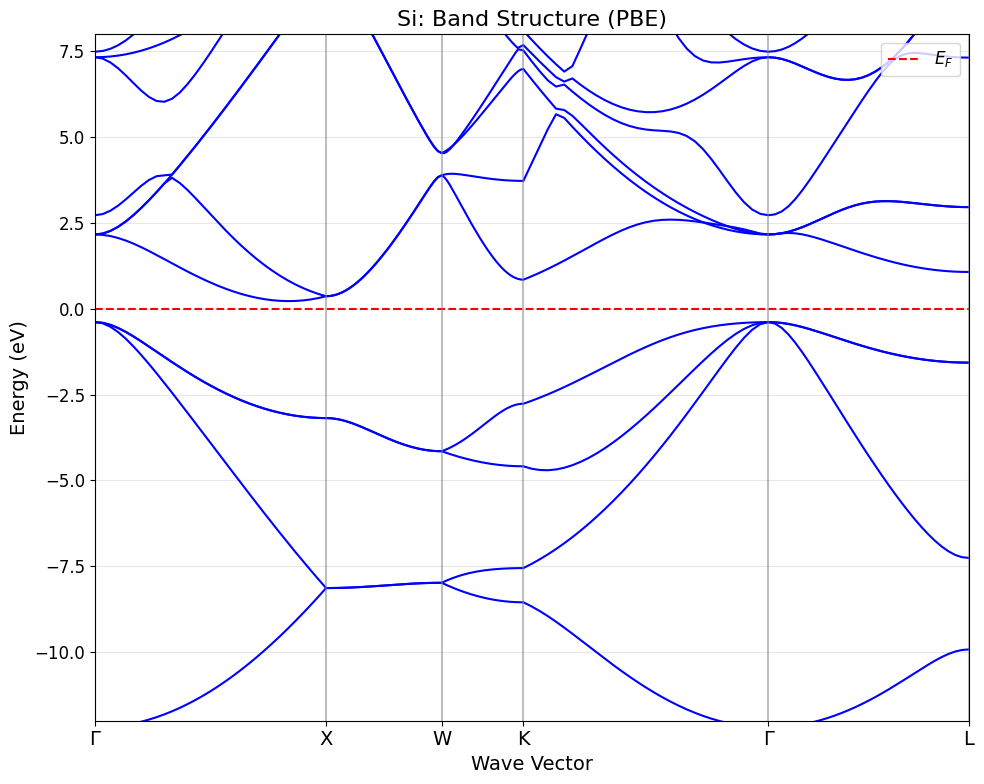


✓ Band structure plot saved: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/08_bands_Si_20260206_010857/Si_band_structure.png
  Estimated band gap (PBE): 0.612 eV


In [11]:
# =============================================================================
# STEP 4: PLOT BAND STRUCTURE
# =============================================================================
# We read the bands.dat.gnu file (k-distance vs energy) and properly
# calculate high-symmetry point positions from the crystal structure.
# =============================================================================

print("\n" + "-"*70)
print("Step 4: Plotting Band Structure")
print("-"*70)

import matplotlib.pyplot as plt

# Parse band data from bands.x output
def parse_bands_data(filename):
    """Parse bands.dat.gnu file produced by bands.x."""
    data = []
    current_band = []
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                if current_band:
                    data.append(current_band)
                    current_band = []
            else:
                parts = line.split()
                if len(parts) >= 2:
                    current_band.append((float(parts[0]), float(parts[1])))
    
    if current_band:
        data.append(current_band)
    
    if not data:
        return None, None
    
    k_dist = np.array([p[0] for p in data[0]])
    bands = np.array([[p[1] for p in band] for band in data]).T
    return k_dist, bands

def compute_hs_positions(atoms, kpath_segments, kpoint_coords, npts_per_segment):
    """
    Compute k-distance positions of high-symmetry points from crystal structure.
    This ensures labels are EXACTLY aligned with the band data.
    """
    # Get reciprocal lattice vectors
    recip = 2 * np.pi * np.linalg.inv(atoms.get_cell().T)
    
    # Build ordered list of k-points in Cartesian coordinates
    ordered_points = []
    for i, (start, end) in enumerate(kpath_segments):
        if i == 0:
            ordered_points.append(start)
        ordered_points.append(end)
    
    # Calculate cumulative k-distance at each high-symmetry point
    hs_positions = [0.0]
    cumulative_dist = 0.0
    
    for i in range(1, len(ordered_points)):
        # Fractional coordinates
        k1 = np.array(kpoint_coords[ordered_points[i-1]])
        k2 = np.array(kpoint_coords[ordered_points[i]])
        
        # Convert to Cartesian
        k1_cart = k1 @ recip
        k2_cart = k2 @ recip
        
        # Distance in reciprocal space
        dk = np.linalg.norm(k2_cart - k1_cart)
        cumulative_dist += dk
        hs_positions.append(cumulative_dist)
    
    # Generate labels
    hs_labels = []
    for name in ordered_points:
        label = name.replace('GAMMA', 'Γ')
        hs_labels.append(label)
    
    return hs_positions, hs_labels

# Find the bands file
bands_file_path = None
for path in [WORK_DIR / f'{prefix}.bands.dat.gnu',
             WORK_DIR / 'tmp' / f'{prefix}.bands.dat.gnu']:
    if path.exists():
        bands_file_path = path
        break

if bands_file_path:
    k_dist, bands = parse_bands_data(bands_file_path)
    
    if k_dist is not None:
        # Compute high-symmetry positions from crystal structure
        hs_positions, hs_labels = compute_hs_positions(
            atoms, kpath_segments, kpoint_coords, npts_per_segment
        )
        
        # Scale hs_positions to match the k_dist range from bands.x
        k_max = k_dist.max()
        hs_max = hs_positions[-1]
        hs_positions_scaled = [p * k_max / hs_max for p in hs_positions]
        
        # Shift bands relative to Fermi energy
        if fermi_energy:
            bands_shifted = bands - fermi_energy
            y_ref_label = '$E_F$'
        else:
            # For semiconductors without Fermi energy, estimate VBM
            vbm = bands[bands < bands.mean()].max()
            bands_shifted = bands - vbm
            y_ref_label = 'VBM'
        
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Plot all bands
        for i in range(bands_shifted.shape[1]):
            ax.plot(k_dist, bands_shifted[:, i], 'b-', linewidth=1.5)
        
        # Fermi level / VBM reference
        ax.axhline(y=0, color='r', linestyle='--', linewidth=1.5, label=y_ref_label)
        
        # High-symmetry point lines and labels
        for pos in hs_positions_scaled:
            ax.axvline(x=pos, color='gray', linestyle='-', alpha=0.5)
        
        ax.set_xticks(hs_positions_scaled)
        ax.set_xticklabels(hs_labels, fontsize=14)
        
        ax.set_ylabel('Energy (eV)', fontsize=14)
        ax.set_xlabel('Wave Vector', fontsize=14)
        ax.set_title(f'{MATERIAL}: Band Structure ({FUNCTIONAL})', fontsize=16)
        ax.set_xlim(k_dist.min(), k_dist.max())
        ax.set_ylim(-12, 8)
        ax.grid(True, alpha=0.3, axis='y')
        ax.legend(loc='upper right')
        
        plt.tight_layout()
        
        fig_path = WORK_DIR / f'{MATERIAL}_band_structure.png'
        fig.savefig(fig_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\n✓ Band structure plot saved: {fig_path}")
        
        # Estimate band gap from bands
        valence = bands_shifted[bands_shifted <= 0]
        conduction = bands_shifted[bands_shifted > 0]
        if len(valence) > 0 and len(conduction) > 0:
            vbm_energy = valence.max()
            cbm_energy = conduction.min()
            band_gap = cbm_energy - vbm_energy
            print(f"  Estimated band gap (PBE): {band_gap:.3f} eV")
        else:
            band_gap = None
            print("  Could not estimate band gap from bands data")
    else:
        print("⚠ Could not parse band data")
        bands_shifted = None
        band_gap = None
else:
    print("⚠ Band data file not found")
    k_dist = None
    bands_shifted = None
    band_gap = None

In [12]:
# =============================================================================
# STEP 5: DENSITY OF STATES (DOS) CALCULATION
# =============================================================================

print("\n" + "="*70)
print("DENSITY OF STATES CALCULATION")
print("="*70)

# NSCF with dense k-mesh for DOS
print("\nStep 5a: NSCF calculation with dense k-mesh...")

nscf_file = WORK_DIR / f'{prefix}_nscf.in'

# Build NSCF input — uses tetrahedra for accurate DOS
nscf_input = f"""&CONTROL
    calculation = 'nscf'
    prefix = '{prefix}'
    outdir = './tmp'
    pseudo_dir = '{get_pseudo_dir(FUNCTIONAL)}'
    verbosity = 'high'
/

&SYSTEM
    ibrav = 0
    nat = {n_atoms}
    ntyp = {len(elements)}
    ecutwfc = {ecutwfc}
    ecutrho = {ecutrho}
    occupations = 'tetrahedra'
    nbnd = 16
/

&ELECTRONS
    conv_thr = 1.0e-8
/

ATOMIC_SPECIES
"""
for el in elements:
    mass = atoms[atoms.get_chemical_symbols().index(el)].mass
    nscf_input += f"    {el}  {mass:.4f}  {get_pseudopotential_filename(el, FUNCTIONAL)}\n"

nscf_input += "\nCELL_PARAMETERS angstrom\n"
for v in atoms.get_cell():
    nscf_input += f"    {v[0]:.10f}  {v[1]:.10f}  {v[2]:.10f}\n"

nscf_input += "\nATOMIC_POSITIONS angstrom\n"
for sym, pos in zip(atoms.get_chemical_symbols(), atoms.get_positions()):
    nscf_input += f"    {sym}  {pos[0]:.10f}  {pos[1]:.10f}  {pos[2]:.10f}\n"

nscf_input += "\nK_POINTS automatic\n    16 16 16 0 0 0\n"

nscf_file.write_text(nscf_input)

output_nscf, elapsed_nscf, _ = run_qe(nscf_file, nprocs=NPROCS)
(WORK_DIR / f'{prefix}_nscf.out').write_text(output_nscf)
print(f"✓ NSCF complete in {elapsed_nscf:.1f}s")

# Run dos.x
print("\nStep 5b: Running dos.x...")

dos_in_file = WORK_DIR / f'{prefix}_dos.in'
dos_input = f"""&DOS
    prefix = '{prefix}'
    outdir = './tmp'
    fildos = '{prefix}.dos.dat'
    Emin = -15.0
    Emax = 10.0
    DeltaE = 0.1
/
"""
dos_in_file.write_text(dos_input)

output_dos, _, _ = run_qe(dos_in_file, executable='dos.x', nprocs=1)
print("✓ dos.x complete")


DENSITY OF STATES CALCULATION

Step 5a: NSCF calculation with dense k-mesh...
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_nscf.in


  ⚠ Completed in 219.2s (check convergence)
✓ NSCF complete in 219.2s

Step 5b: Running dos.x...
Running: /home/niel/src/qe-7.5/bin/dos.x -in si_dos.in


  ⚠ Completed in 2.2s (check convergence)
✓ dos.x complete



Step 6: Plotting DOS...


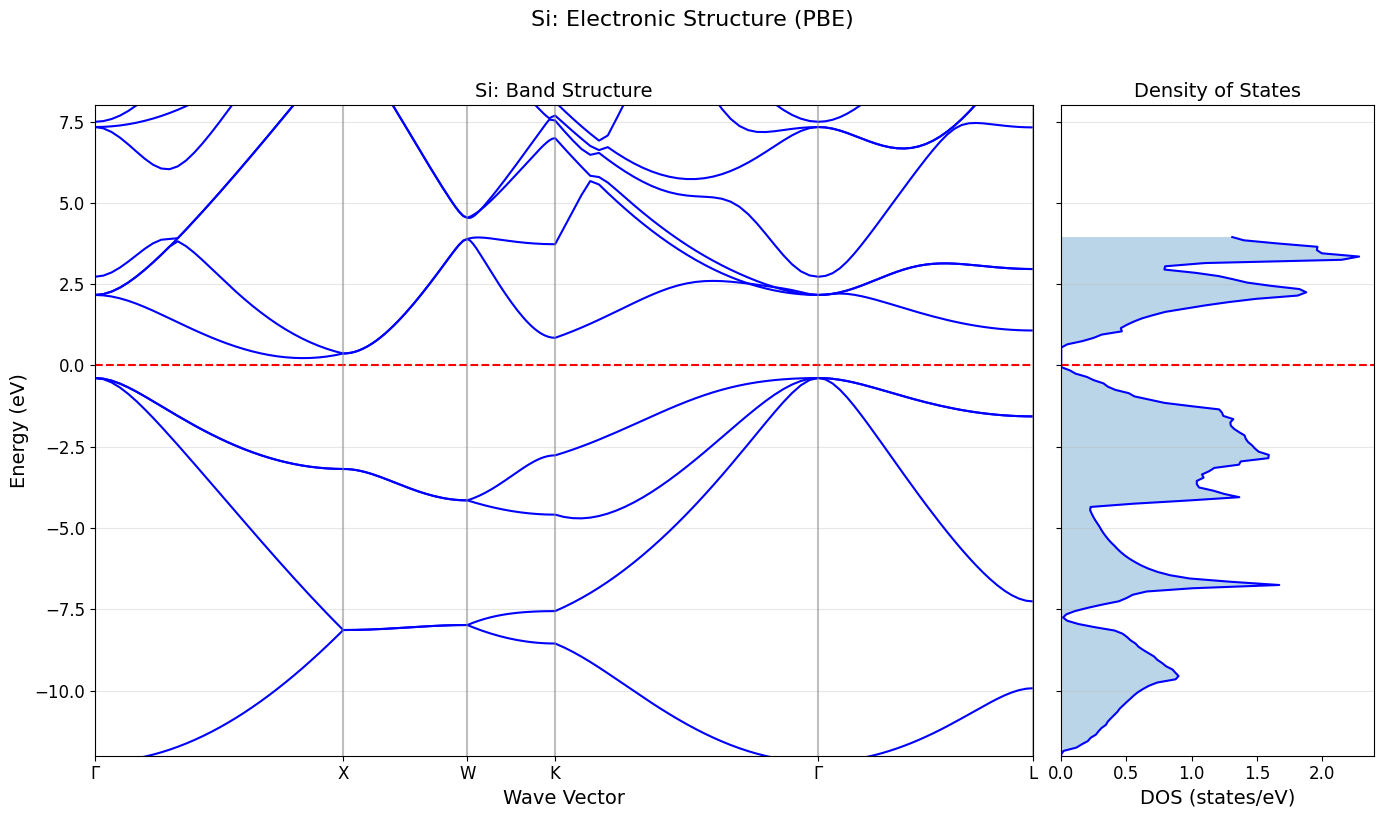


✓ Combined plot saved: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/08_bands_Si_20260206_010857/Si_bands_dos.png


In [13]:
# =============================================================================
# STEP 6: PLOT DOS AND COMBINED BAND+DOS FIGURE
# =============================================================================

print("\nStep 6: Plotting DOS...")

# Parse DOS data
dos_file = WORK_DIR / f'{prefix}.dos.dat'
if not dos_file.exists():
    dos_file = WORK_DIR / 'tmp' / f'{prefix}.dos.dat'

if dos_file.exists():
    energy_dos = []
    dos_values = []
    fermi_dos = None
    
    with open(dos_file, 'r') as f:
        for line in f:
            if line.startswith('#'):
                match = re.search(r'EFermi\s*=\s*([\d.+-]+)', line)
                if match:
                    fermi_dos = float(match.group(1))
                continue
            parts = line.split()
            if len(parts) >= 2:
                energy_dos.append(float(parts[0]))
                dos_values.append(float(parts[1]))
    
    energy_dos = np.array(energy_dos)
    dos_values = np.array(dos_values)
    
    if fermi_dos is None:
        fermi_dos = fermi_energy or 0
    
    # Shift to Fermi level
    energy_shifted_dos = energy_dos - fermi_dos
    
    # Create combined band structure + DOS plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), 
                                    gridspec_kw={'width_ratios': [3, 1]},
                                    sharey=True)
    
    # Left: Band structure
    if k_dist is not None and bands_shifted is not None:
        for i in range(bands_shifted.shape[1]):
            ax1.plot(k_dist, bands_shifted[:, i], 'b-', linewidth=1.5)
        ax1.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
        for pos in hs_positions_scaled:
            ax1.axvline(x=pos, color='gray', linestyle='-', alpha=0.5)
        ax1.set_xticks(hs_positions_scaled)
        ax1.set_xticklabels(hs_labels, fontsize=12)
        ax1.set_ylabel('Energy (eV)', fontsize=14)
        ax1.set_xlabel('Wave Vector', fontsize=14)
        ax1.set_title(f'{MATERIAL}: Band Structure', fontsize=14)
        ax1.set_xlim(k_dist.min(), k_dist.max())
        ax1.set_ylim(-12, 8)
        ax1.grid(True, alpha=0.3, axis='y')
    
    # Right: DOS
    ax2.plot(dos_values, energy_shifted_dos, 'b-', linewidth=1.5)
    ax2.fill_betweenx(energy_shifted_dos, 0, dos_values, alpha=0.3)
    ax2.axhline(y=0, color='r', linestyle='--', linewidth=1.5, label='$E_F$')
    ax2.set_xlabel('DOS (states/eV)', fontsize=14)
    ax2.set_title('Density of States', fontsize=14)
    ax2.set_ylim(-12, 8)
    ax2.set_xlim(0, None)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'{MATERIAL}: Electronic Structure ({FUNCTIONAL})', fontsize=16, y=1.02)
    plt.tight_layout()
    
    fig_path = WORK_DIR / f'{MATERIAL}_bands_dos.png'
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Combined plot saved: {fig_path}")
else:
    print("⚠ DOS data file not found")

In [14]:
# =============================================================================
# SUMMARY: Electronic Properties Results
# =============================================================================

# Silicon experimental band gap
si_exp_gap = 1.17  # eV (indirect)

print("="*70)
print(f"NOTEBOOK 08 SUMMARY: {MATERIAL} Electronic Properties")
print("="*70)

print(f"""
CALCULATION SUMMARY:
--------------------
Material:           {MATERIAL} ({STRUCTURE_TYPE})
Lattice parameter:  {a0_opt:.4f} Å (optimized from NB05)
Functional:         {FUNCTIONAL}
ecutwfc:            {ecutwfc} Ry

RESULTS:
--------
Total energy:       {results_scf['total_energy_ev']:.6f} eV
""")

if fermi_energy:
    print(f"Fermi energy:       {fermi_energy:.4f} eV")

print(f"\nBAND GAP ({FUNCTIONAL}):")
print(f"-"*30)
if band_gap is not None:
    print(f"Calculated:         {band_gap:.3f} eV")
    print(f"Experimental:       {si_exp_gap} eV (indirect)")
    if band_gap > 0:
        print(f"PBE underestimate:  ~{(si_exp_gap-band_gap)/si_exp_gap*100:.0f}%")
else:
    print("Band gap: see plot above")

print(f"""
KEY LESSONS:
------------
1. Si has an indirect band gap (Γ → near X)
2. PBE significantly underestimates band gap (~50% for Si)
3. For accurate gaps: use HSE06 hybrid functional or GW methods
4. DOS shows clear valence-conduction band separation

OUTPUT FILES:
-------------
SCF output:   {WORK_DIR / f'{prefix}_scf.out'}
Bands output: {WORK_DIR / f'{prefix}_bands.out'}
DOS data:     {WORK_DIR / f'{prefix}.dos.dat'}
Band plot:    {WORK_DIR / f'{MATERIAL}_band_structure.png'}
Combined:     {WORK_DIR / f'{MATERIAL}_bands_dos.png'}
""")

print("="*70)

NOTEBOOK 08 SUMMARY: Si Electronic Properties

CALCULATION SUMMARY:
--------------------
Material:           Si (diamond)
Lattice parameter:  5.4698 Å (optimized from NB05)
Functional:         PBE
ecutwfc:            45.0 Ry

RESULTS:
--------
Total energy:       -310.756277 eV

Fermi energy:       6.3643 eV

BAND GAP (PBE):
------------------------------
Calculated:         0.612 eV
Experimental:       1.17 eV (indirect)
PBE underestimate:  ~48%

KEY LESSONS:
------------
1. Si has an indirect band gap (Γ → near X)
2. PBE significantly underestimates band gap (~50% for Si)
3. For accurate gaps: use HSE06 hybrid functional or GW methods
4. DOS shows clear valence-conduction band separation

OUTPUT FILES:
-------------
SCF output:   /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/08_bands_Si_20260206_010857/si_scf.out
Bands output: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/08_bands_Si_20260206_010857/si_bands.out
DOS data:     /home/niel/git/DFT_Tutorial/qe_works

---

## Summary

### Electronic Property Calculations

| Property | Method | Key Parameters |
|----------|--------|----------------|
| Band structure | SCF → bands → bands.x | K-path, nbnd |
| DOS | SCF → NSCF → dos.x | Dense k-mesh, tetrahedra |
| PDOS | ... → projwfc.x | Orbital projections |
| Effective mass | From band curvature | d²E/dk² |

### Key Reminders

1. **ALWAYS verify stability first**
2. **DFT underestimates band gaps** - don't trust quantitatively
3. **Use dense k-mesh for DOS** - at least 2× the SCF grid
4. **Qualitative trends are reliable** - direct vs indirect, orbital character

### Next Notebook
→ **09_Advanced_Properties.ipynb**: Optical, transport, and other properties